# Exercises - GEO4902-02 - Data Assimilation

[Save as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 02-03 -  Single observation data assimilation experiment

In [86]:
# import python packages
import xarray as xr
import math
import numpy as np
from matplotlib import pyplot as plt
import cartopy as cy
from cmcrameri import cm

#### Load BACKGROUND fields of temperature,wind, and specific humidity

In [87]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.BG.nc'
model_background = xr.open_dataset(url)

#### Load ANALYSIS fields of temperature,wind, and specific humidity
#### This analysis has been produced by assimilating a radiosonde information at 500hPa

In [88]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.LPB_POS2_TEMP500.nc'
model_analysis = xr.open_dataset(url)

The data is stored in the original coordinates of the model, but do not worry about that. Just assume it is some kind of vertical discretization. Remember that you can look in the metadata to find the variable names and coordinate information! 

### Below are two plotting routines which yo can use to plot horizontal and vertical sections of the model. 

In [89]:
# finding model level with largest difference. Assuming this is the assimilation location.
timestep=0
mlvls = np.arange(1,61)
diff = 0
level = 0
for modellevel in mlvls:
    temp_background = model_background['air_temperature'].isel(time=timestep).sel(lev_2=modellevel)
    temp_analysis   = model_analysis['air_temperature'].isel(time=timestep).sel(lev=modellevel)
    difference = np.abs(temp_background - temp_analysis)
    max_diff = np.max(difference).values
    if max_diff > diff:
        diff = max_diff
        level = modellevel
print(f'modellevel: {level}      difference: {diff}')

modellevel: 39      difference: 0.4365386962890625


In [90]:
timestep=0; modellevel=39
temp_background = model_background['air_temperature'].isel(time=timestep).sel(lev_2=modellevel)
temp_analysis   = model_analysis['air_temperature'].isel(time=timestep).sel(lev=modellevel)

In [91]:
difference = np.abs(temp_background - temp_analysis)
# Find the index of the maximum difference
max_diff_index = np.unravel_index(np.argmax(difference.values), difference.shape)
print(np.argmax(difference.values))
# Extract the latitude and longitude corresponding to this index
lat_with_max_diff = difference['lat'].values[max_diff_index[0]]
lon_with_max_diff = difference['lon'].values[max_diff_index[1]]

# Print the results
print(f'Model level: {modellevel}')
print(f'Maximum difference: {difference.values[max_diff_index]}')
print(f'Location of max difference - Latitude: {lat_with_max_diff}, Longitude: {lon_with_max_diff}')

63600
Model level: 39
Maximum difference: nan
Location of max difference - Latitude: 76.19999694824219, Longitude: 350.0


This indicates that the data was assimilated at model level 39 and at Latitude: 76.19999694824219, Longitude: 350.0.
Although the plot below seems to show the assimilated location to be closer to atitude: 60, Longitude: 360.0, which seems much more reasonable. So there is something wrong with the method above.

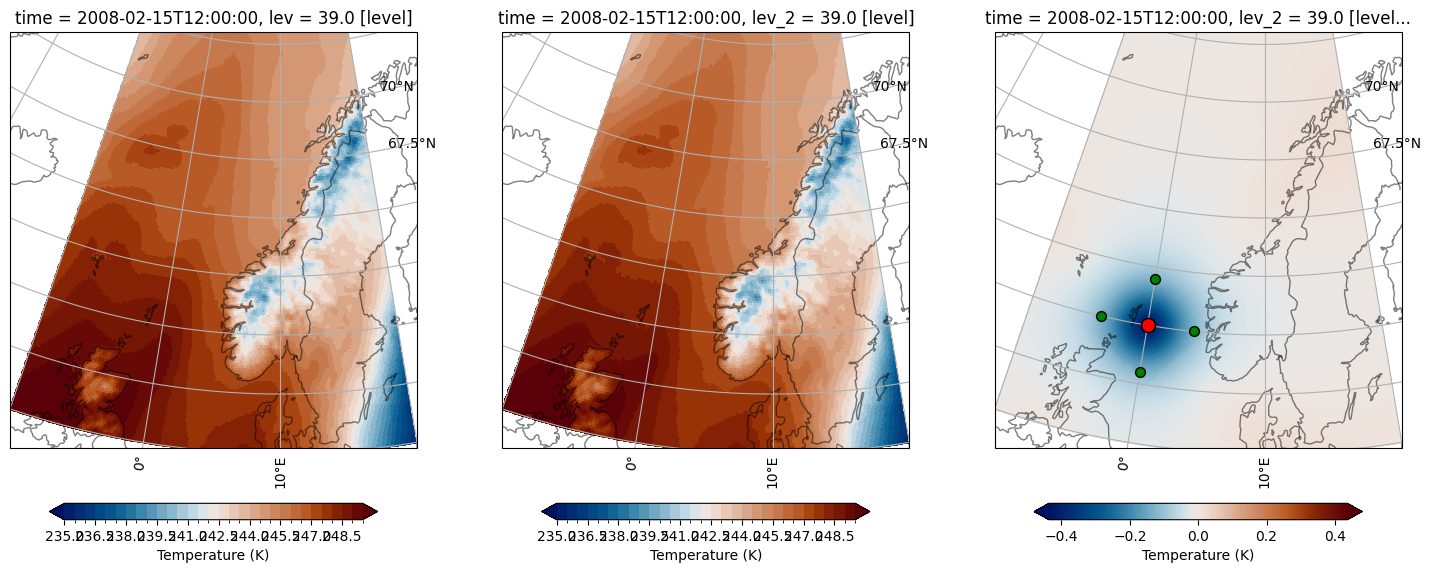

In [92]:
projection = cy.crs.Stereographic(central_latitude=78.4, central_longitude=10.0, )
# projection = cy.crs.PlateCarree()
f, axes = plt.subplots(1,3, subplot_kw={'projection':projection}, figsize=[18, 7.2])
# plot cosmetics
for ax in axes:
    ax.set_extent([-10, 20, 55, 72], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False

temp_analysis.plot.pcolormesh(ax=axes[0], 
                              x='lon',
                              y='lat',
                              cmap=cm.vik,
                              extend='both',
                              levels=np.arange(235, 250,.5),
                              transform=cy.crs.PlateCarree(), 
                              cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.8, 'pad':0.1})

temp_background.plot.pcolormesh(ax=axes[1], 
                              x='lon',
                              y='lat',
                              cmap=cm.vik,
                              extend='both',
                              levels=np.arange(235, 250,.5),
                              transform=cy.crs.PlateCarree(), 
                              cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.8, 'pad':0.1})

difference = temp_background - temp_analysis

difference.plot.pcolormesh(ax=axes[2], 
                              x='lon',
                              y='lat',
                              cmap=cm.vik,
                              extend='both',
                              transform=cy.crs.PlateCarree(), 
                              cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.8, 'pad':0.1})
axes[2].scatter(360, 60, color='red', s=100, edgecolor='black', transform=cy.crs.PlateCarree(), zorder=5)
axes[2].scatter(360, 62, color='green', s=50, edgecolor='black', transform=cy.crs.PlateCarree(), zorder=5)
axes[2].scatter(360, 58, color='green', s=50, edgecolor='black', transform=cy.crs.PlateCarree(), zorder=5)
axes[2].scatter(356, 60, color='green', s=50, edgecolor='black', transform=cy.crs.PlateCarree(), zorder=5)
axes[2].scatter(364, 60, color='green', s=50, edgecolor='black', transform=cy.crs.PlateCarree(), zorder=5)

plt.show()


In [93]:
timestep=0; seclat=50; # Intersection at latitude model_analysis.lat[seclat]

tempvert_background = model_background['air_temperature'].isel(time=timestep, lat=seclat)
tempvert_analysis   = model_analysis['air_temperature'].isel(time=timestep, lat=seclat)

windvert_background =(np.sqrt(model_background['x_wind']**2 + model_background['y_wind']**2)).isel(time=timestep, lat=seclat)
windvert_analysis   =(np.sqrt(model_analysis['x_wind']**2 + model_analysis['y_wind']**2)).isel(time=timestep, lat=seclat)

humidvert_background = model_background['specific_humidity'].isel(time=timestep, lat=seclat)
humidvert_analysis   = model_analysis['specific_humidity'].isel(time=timestep, lat=seclat)

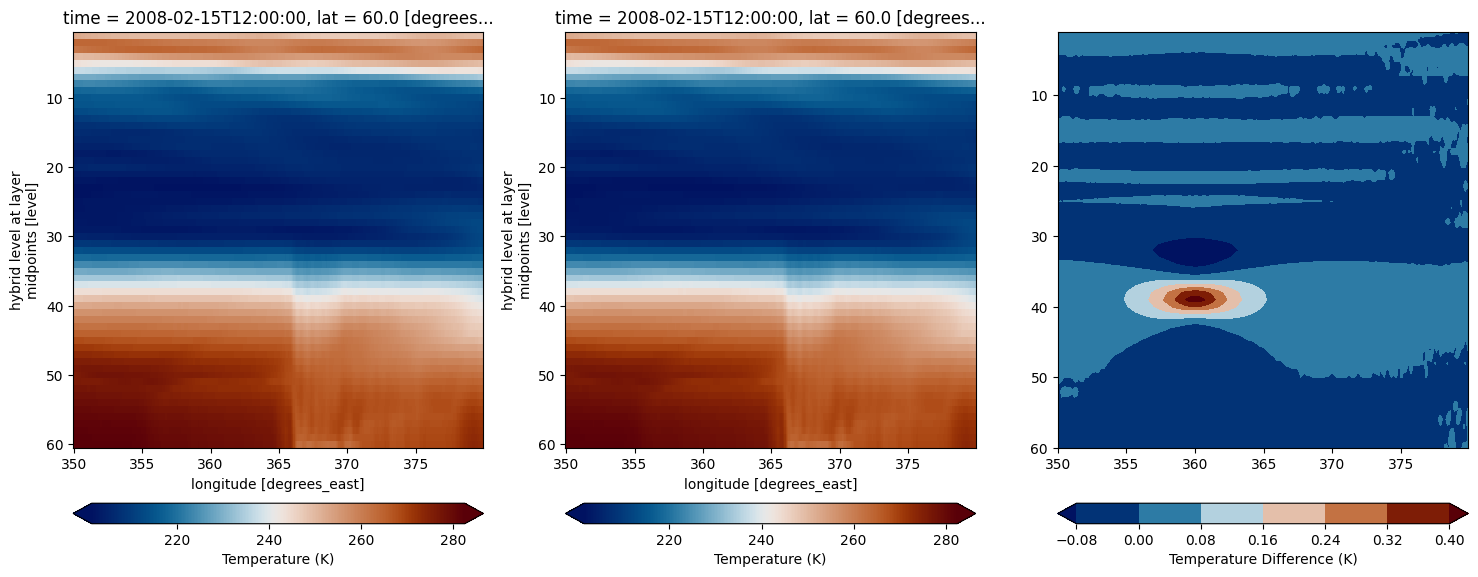

In [94]:
f, ax = plt.subplots(1,3,figsize=[18, 7.2])

tempvert_background.plot(ax=ax[0], 
                         x='lon', 
                         y='lev_2', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(253.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':1, 'pad':0.1})
ax[0].set_ylim(ax[0].get_ylim()[::-1])

tempvert_analysis.plot(ax=ax[1], 
                         x='lon', 
                         y='lev', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(213.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':1, 'pad':0.1})
ax[1].set_ylim(ax[1].get_ylim()[::-1])

diff = tempvert_analysis-tempvert_background
diff_val = tempvert_analysis.values-tempvert_background.values
lon = diff['lon'].values
lev_2 = diff['lev_2'].values
diff_values = diff_val

contour = ax[2].contourf(lon, lev_2, diff_values, cmap=cm.vik, extend='both')

# Add a colorbar manually with customized options
cbar = f.colorbar(contour, ax=ax[2], orientation='horizontal', shrink=1, pad=0.1)
cbar.set_label('Temperature Difference (K)')

# Reverse the y-axis to make levels go from top (low pressure) to bottom (high pressure)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
plt.show()


At level 39 the temperature assimilation has an obvious geographical impact of about 3 degrees on average in each direction. Assuming 1 deg $\approx$ 100 km, this means it affects an area of
$$
\pi R^2 = \pi (300 \text{km})^2 \approx 283000 \text{km}^2
$$
It should be noted tht there is a slight effect on the entire domain.

Although the affected area looks round on the map, this is just an artifact of the projection. The spatial impact seems to be twice as strong in the longitudinal direction compared to the latitudinal. Furthermore, higher and lower levels than level 39 are affected less aggressively at the assimilation location but more evenly over the entire domain.

Wind and humidity presumably change due to their dependence on temperature in the model. Changing the temperature field will change geostrophic contours as well as the vertical changes in temperature which will change the winds due to the thermal wind relation.

Results for wind speed and specific humidity are shown below. Both show increases near the temperature increase and decreases in some areas.

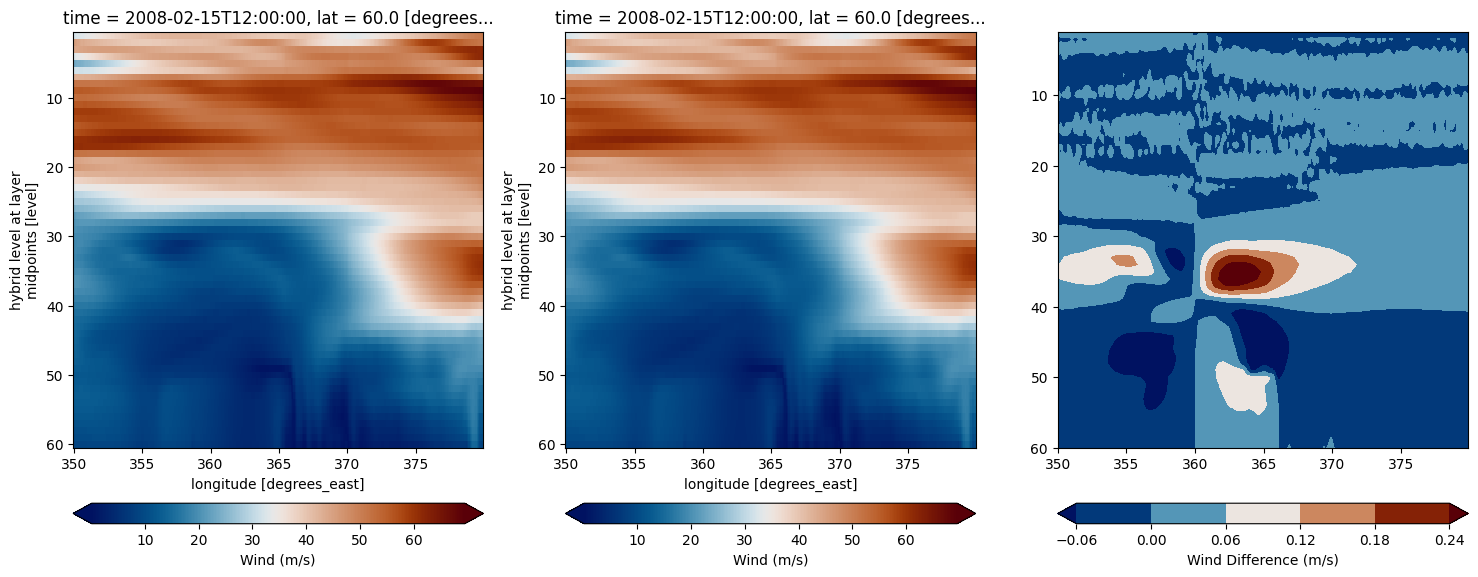

In [95]:
f, ax = plt.subplots(1,3,figsize=[18, 7.2])

windvert_background.plot(ax=ax[0], 
                         x='lon', 
                         y='lev_2', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(253.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'Wind (m/s)', 'shrink':1, 'pad':0.1})
ax[0].set_ylim(ax[0].get_ylim()[::-1])

windvert_analysis.plot(ax=ax[1], 
                         x='lon', 
                         y='lev', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(213.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'Wind (m/s)', 'shrink':1, 'pad':0.1})
ax[1].set_ylim(ax[1].get_ylim()[::-1])

diff = windvert_analysis-windvert_background
diff_val = windvert_analysis.values-windvert_background.values
lon = diff['lon'].values
lev_2 = diff['lev_2'].values
diff_values = diff_val

contour = ax[2].contourf(lon, lev_2, diff_values, cmap=cm.vik, extend='both')

# Add a colorbar manually with customized options
cbar = f.colorbar(contour, ax=ax[2], orientation='horizontal', shrink=1, pad=0.1)
cbar.set_label('Wind Difference (m/s)')

# Reverse the y-axis to make levels go from top (low pressure) to bottom (high pressure)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
plt.show()

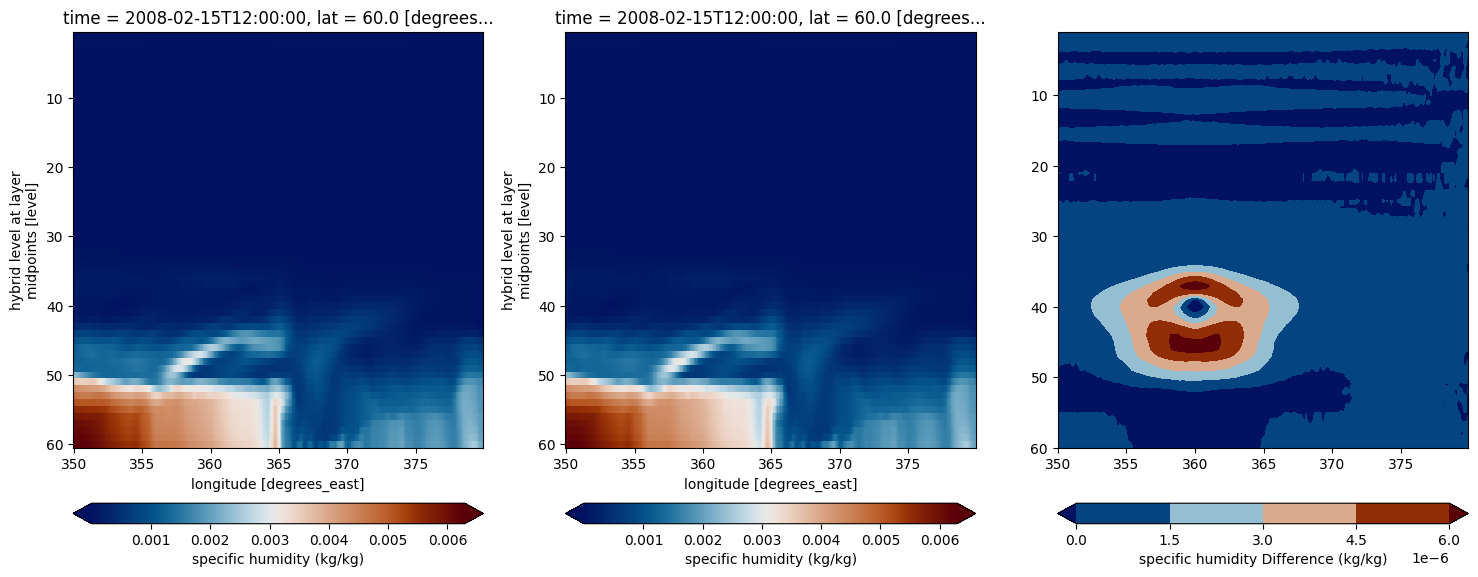

In [96]:
f, ax = plt.subplots(1,3,figsize=[18, 7.2])

humidvert_background.plot(ax=ax[0], 
                         x='lon', 
                         y='lev_2', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(253.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1, 'pad':0.1})
ax[0].set_ylim(ax[0].get_ylim()[::-1])

humidvert_analysis.plot(ax=ax[1], 
                         x='lon', 
                         y='lev', 
                         cmap=cm.vik, 
                         extend='both', 
                        #  levels=np.arange(213.15, 293.15,2),
                         cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1, 'pad':0.1})
ax[1].set_ylim(ax[1].get_ylim()[::-1])

diff = humidvert_analysis-humidvert_background
diff_val = humidvert_analysis.values-humidvert_background.values
lon = diff['lon'].values
lev_2 = diff['lev_2'].values
diff_values = diff_val

contour = ax[2].contourf(lon, lev_2, diff_values, cmap=cm.vik, extend='both')

# Add a colorbar manually with customized options
cbar = f.colorbar(contour, ax=ax[2], orientation='horizontal', shrink=1, pad=0.1)
cbar.set_label('specific humidity Difference (kg/kg)')

# Reverse the y-axis to make levels go from top (low pressure) to bottom (high pressure)
ax[2].set_ylim(ax[2].get_ylim()[::-1])
plt.show()
